In [9]:
import pandas as pd
# !pip install scipy==1.12
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

In [2]:
data_folder = r'/Users/AdamHarris/Documents/neuromatch_nlp/Neuromatch_NLP/dataset'

true_processed = pd.read_csv(data_folder+ '/true_preprocessed_emotion.csv')
fake_processed = pd.read_csv(data_folder+ '/fake_preprocessed_emotion.csv')
data_all_processed = pd.concat([true_processed,fake_processed], ignore_index=True)


In [25]:
len(fake_processed)/(len(true_processed)+len(fake_processed))

0.516186603411273

In [6]:
corpus = list(data_all_processed['text'])

In [28]:
labels = np.array(data_all_processed['label'])

In [10]:
# preproces the documents, and create TaggedDocuments
tagged_data = [TaggedDocument(words=word_tokenize(doc.lower()),
                              tags=[str(i)]) for i,
                              doc in enumerate(corpus)]

In [11]:
tagged_data

[TaggedDocument(words=['washington', 'head', 'conservative', 'republican', 'faction', 'u', 'congress', 'voted', 'month', 'huge', 'expansion', 'national', 'debt', 'pay', 'tax', 'cuts', 'called', 'fiscal', 'conservative', 'sunday', 'urged', 'budget', 'restraint', 'keeping', 'sharp', 'pivot', 'way', 'among', 'republicans', 'u', 'representative', 'mark', 'meadows', 'speaking', 'cbs', 'face', 'nation', 'drew', 'hard', 'line', 'federal', 'spending', 'lawmakers', 'bracing', 'battle', 'january', 'return', 'holidays', 'wednesday', 'lawmakers', 'begin', 'trying', 'pass', 'federal', 'budget', 'fight', 'likely', 'linked', 'issues', 'immigration', 'policy', 'even', 'november', 'congressional', 'election', 'campaigns', 'approach', 'republicans', 'seek', 'keep', 'control', 'congress', 'president', 'donald', 'trump', 'republicans', 'want', 'big', 'budget', 'increase', 'military', 'spending', 'democrats', 'also', 'want', 'proportional', 'increases', 'non', 'defense', 'discretionary', 'spending', 'progr

In [12]:
vec_size = 200
model = Doc2Vec(vector_size=vec_size,
                min_count=2, epochs=100)

In [13]:
model.build_vocab(tagged_data)

In [14]:
model.train(tagged_data,
            total_examples=model.corpus_count,
            epochs=model.epochs)

In [15]:
document_vectors = [model.infer_vector(word_tokenize(doc.lower())) for doc in corpus]

In [22]:
doc_arrays = np.vstack(document_vectors)
np.save(f'{data_folder}/doc2vec_embeddings_{vec_size}.npy', doc_arrays)

In [29]:
doc_arrays.shape

(44265, 200)

In [32]:


similarity_matrix = cosine_similarity(doc_arrays)

In [33]:
threshold = 0.8
adjacency_matrix = np.where(similarity_matrix > threshold, similarity_matrix, 0)

In [ ]:
adjacency_matrix.shape()

array([[0.9999997, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.0000001, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.9999997,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.9999999]], dtype=float32)

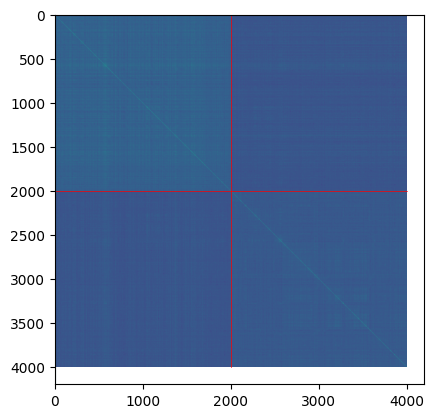

In [109]:
x = len(true_processed)
plt.imshow(similarity_matrix[x-2000:x+2000,x-2000:x+2000])
plt.plot([2000, 2000], [0, 4000], color='red', linewidth=0.5)

plt.plot([0, 4000],[2000, 2000], color='red', linewidth=0.5)
plt.axvline()

In [90]:
# Create a graph from the adjacency matrix
graph = nx.from_numpy_array(adjacency_matrix)
color_map = plt.get_cmap('viridis', 2)
# Optionally, remove self-loops
graph.remove_edges_from(nx.selfloop_edges(graph))

In [133]:
pos = nx.spring_layout(graph)
nx.draw(graph, pos, node_color=labels, with_labels=True, node_size=50, cmap=color_map)

In [ ]:
sub_inds = np.random.choice(list(graph.nodes), 100, replace=False)

labels_sub = labels[sub_inds]
subgraph = graph.subgraph([list(graph.nodes)[i] for i in sub_inds])


# subgraph_colors = [node_colors[node] for node in subgraph.nodes]

In [ ]:
subgraph.edges

EdgeView([])

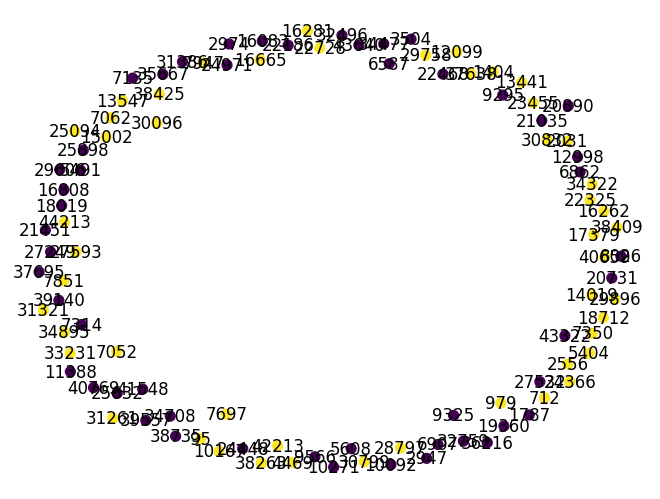

In [ ]:
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color=labels_sub, with_labels=True, node_size=50, cmap=color_map, edge_color='black')

Explained variance by each component: [0.0148787  0.01424403 0.01319565 0.01211719 0.01071187 0.01022979
 0.00936388 0.00881324 0.00862483 0.00852695]


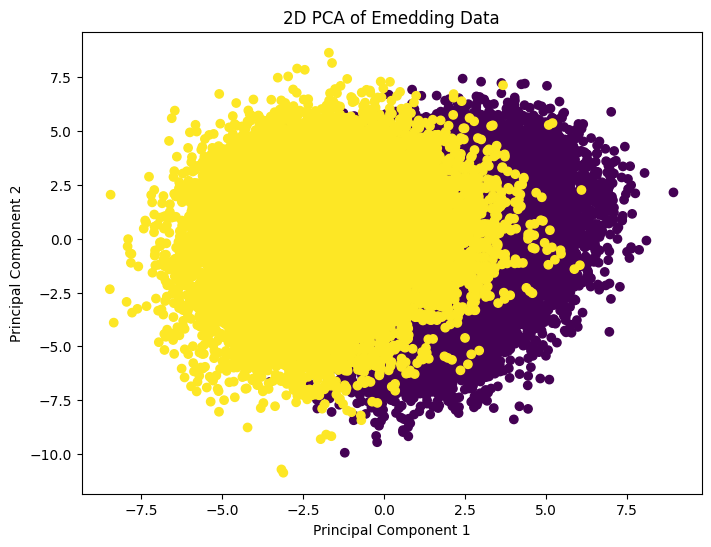

In [131]:
pca = PCA(n_components=10)
projected_data = pca.fit_transform(doc_arrays)
explained_variance = pca.explained_variance_ratio_
print("Explained variance by each component:", explained_variance)
projected_df = pd.DataFrame(data=projected_data, columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10'])
# Scatter plot of the principal components
plt.figure(figsize=(8,6))
plt.scatter(projected_df['PC1'], projected_df['PC2'], c=labels)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Emedding Data')
plt.show()

In [120]:
projected_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,1.968994,3.591256,1.925790,0.861228,2.337918,2.817137,1.306749,2.066365,0.393802,0.073750
1,2.273382,0.882024,1.127300,-2.202033,4.399831,0.767161,-1.499974,-3.780290,0.535513,-4.132637
2,2.005422,2.395942,-5.027842,-3.764515,-3.241788,2.207461,-2.146267,-0.152622,-0.095011,-2.011013
3,2.837039,0.874514,-4.416576,-1.973795,-5.746480,0.612885,-1.892720,-0.276160,1.556420,-0.324880
4,3.119381,4.073062,3.310956,-0.676995,-0.517925,-5.735485,-1.497802,1.327302,3.572145,2.050714
...,...,...,...,...,...,...,...,...,...,...
44260,1.624926,0.097325,-5.467573,0.071287,4.337323,-1.936229,3.572243,0.119550,-2.371077,1.884407
44261,0.871315,0.579146,2.942886,-5.007394,1.302236,-0.460172,0.992218,-3.967184,0.717943,-2.036011
44262,1.806919,-2.396173,-3.391632,0.862738,1.753354,-0.448144,6.498002,0.089254,-0.573484,-1.085653
44263,-1.306813,1.656480,-2.174317,0.520495,-0.130582,-4.452360,3.698800,-0.390883,-1.597674,5.249365


In [119]:
projected_data.shape


(44265, 10)

In [112]:
doc_arrays

array([[ 0.7909544 , -0.42995736, -3.031353  , ..., -0.6863127 ,
         1.7143763 , -0.22269426],
       [ 0.20082125, -3.193448  ,  0.8519964 , ...,  2.1866224 ,
        -0.3050653 ,  1.4497322 ],
       [ 2.2076602 ,  1.960617  , -0.6596099 , ...,  0.2221561 ,
         0.0331642 , -0.3544937 ],
       ...,
       [-2.8764942 , -2.7745898 , -0.23988768, ..., -2.9891756 ,
         2.9814994 ,  0.09315304],
       [-0.5454294 , -4.5619087 ,  2.1280375 , ..., -0.92485595,
        -0.6987999 ,  0.46468088],
       [-0.99735445,  0.5954661 ,  0.28139916, ..., -1.390187  ,
        -1.1243305 , -0.21904002]], dtype=float32)

In [128]:
import umap.umap_ as umap

/Users/AdamHarris/miniconda3/envs/par2vec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [129]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(doc_arrays)


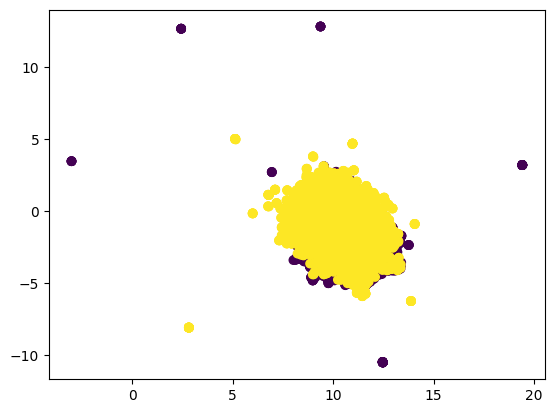

In [130]:
plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=labels)